<a href="https://colab.research.google.com/github/alekswheeler/datasci_home_work/blob/main/Especifica%C3%A7%C3%A3o_2024_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático

O objetivo geral deste trabalho é praticar os conceitos discutidos em sala de aula, principalmente: representação e pré-processamento de dados textuais; redução de dimensionalidade e algoritmos de agrupamento.

## Conjunto de Dados

Para esse trabalho utilizaremos um conjunto de dados de filmes. Os dados foram obtidos de várias fontes, incluindo IMDB.

O conjunto de dados que vocês deverão usar encontra-se no AVA da disciplina. Os dados estão organizados um arquivo (`.csv`) com as seguintes colunas:

* **genres** - gêneros a que um filme pertence. Veja que um filme pode estar associado a mais de um gênero (`str`);
* **sinopse** - sinopse do filme (`str`);
* **startYear** - ano de lançamento do filme (`int`);
* **primaryTitle** - título do filme (`str`);
* **runtimeMinutes** - duração do filme, em minutos (`int`);
* **averageRating** - média das avaliações do filme (`float`);
* **numVotes** - número de avaliações do filme (`int`);
* **actors_names** - atores/atrizes principais (`str`);
* **directors_names** - diretores(as) do filme (`str`).

**Observação:** esse conjunto de dados é uma versão transformada dos dados originais. Por exemplo, gêneros muito populares ou raros foram removidos.

**ATENÇÃO**
É possível que seu computador não consiga lidar com o conjunto de dados completo. Se for o caso, faça uma amostra aleatória de filmes do conjunto de dados. Deixe claro o processo de amostragem, o tamanho das amostras finais que considerou no trabalho e as especificações do computador utilizado.

Os comandos abaixo mostram como os dados podem ser obtidos e carregados em um `DataFrame`.

In [31]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg' -O filmes.csv



--2025-02-18 00:08:22--  https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg
Resolving docs.google.com (docs.google.com)... 172.253.62.100, 172.253.62.138, 172.253.62.102, ...
Connecting to docs.google.com (docs.google.com)|172.253.62.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg&export=download [following]
--2025-02-18 00:08:22--  https://drive.usercontent.google.com/download?id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.163.132, 2607:f8b0:4004:c1b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.163.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11380332 (11M) [application/octet-stream]
Saving to: ‘filmes.csv’

filmes.csv          100%[===================>]  10.85M  45.4MB/s    in 

In [32]:
import pandas as pd
df = pd.read_csv("filmes.csv")

In [33]:
df.head()
a = df['sinopse']

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
D = ["É escória échange", "this is 1980  a another people and", "example example example"]

vectorizer = TfidfVectorizer(token_pattern=r'\b[a-zA-ZÀ-ÖØ-öø-ÿ]+\b', stop_words='english')
vectorizer.fit_transform(D)
vectorizer.get_feature_names_out()

array(['escória', 'example', 'people', 'é', 'échange'], dtype=object)

## Objetivo

Vocês deverão utilizar aprendizado não supervisionado (neste caso, agrupamento) para investigar se há relação entre a **sinopse** de um filme e o(s) **gênero(s)** a que pertence.

De forma mais específica, vocês deverão agrupar os filmes de acordo suas sinopses e, após isso, verificar a distribuição dos gêneros em cada grupo. Ou seja, se os filmes pertencentes ao mesmo grupo possuem o(s) mesmo(s) gênero(s) ou se as distribuições de gêneros de grupos diferentes são distintas.

## Trabalho

Antes de fazer o pré-processamento de dados a ideia é que vamos dividir a base de dados em pedaços menores mantendo a proporção da base de dados original ([StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)).

In [35]:
X = df.drop(columns=['genres'])
y = df['genres']

In [74]:
generos = y.unique()

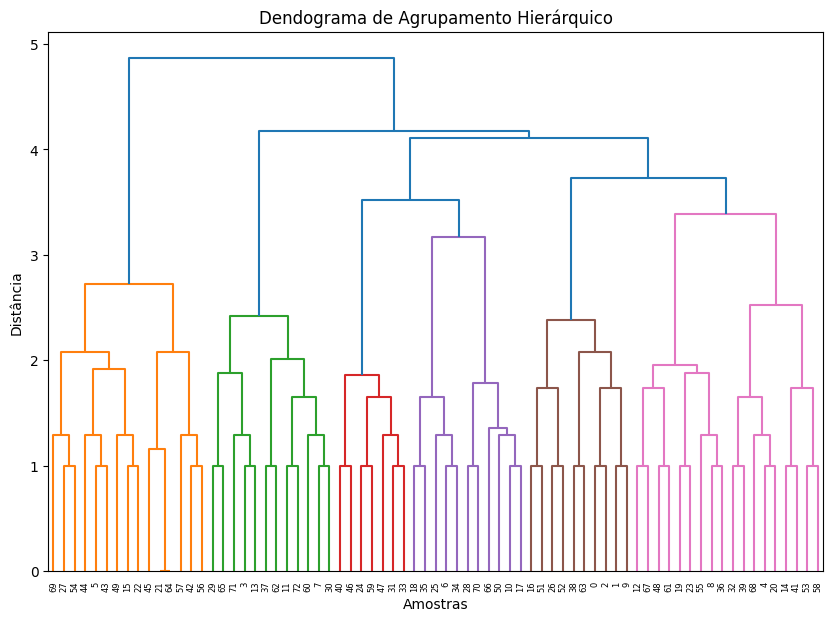

In [77]:
# usando aglomerativo para decidir os grupos
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Quebrando os gêneros por vírgula para cada filme
generos_split = [g.split(',') for g in generos]

# Aplicando MultiLabelBinarizer para One-Hot Encoding
mlb = MultiLabelBinarizer()
generos_encoded = mlb.fit_transform(generos_split)

# Convertendo para DataFrame para melhor visualização
df_generos = pd.DataFrame(generos_encoded, columns=mlb.classes_)

num_clusters = 7

# Calculando as ligações para o dendograma
hierarchical_model = AgglomerativeClustering(n_clusters=num_clusters,linkage='ward')
Z = linkage(generos_encoded, method='ward')

# Plotando o dendograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendograma de Agrupamento Hierárquico')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()

In [78]:
clusters = hierarchical_model.fit_predict(generos_encoded)

# Adicionando os rótulos dos clusters ao DataFrame original
df_generos['Cluster'] = clusters
df_generos['Original'] = generos  # Mantendo os gêneros originais para referência

# Exibindo as classes agrupadas
print("\nAgrupamento de gêneros por cluster:")
for i in range(num_clusters):
    print(f"\nCluster {i}:")
    print(df_generos[df_generos['Cluster'] == i]['Original'].values)


Agrupamento de gêneros por cluster:

Cluster 0:
['Biography' 'Sport,Family' 'Sport' 'Crime,Biography' 'Biography,Action'
 'Sport,Biography' 'Biography,Family' 'Crime,Biography,Action'
 'Sport,Musical' 'Sport,Horror' 'Sport,Biography,Family']

Cluster 1:
['Horror' 'Sci-Fi,Horror' 'Crime,Horror' 'Sci-Fi,Horror,Action'
 'Horror,Action' 'Musical,Horror' 'Horror,Family' 'Horror,Biography'
 'Crime,Sci-Fi,Horror' 'Sci-Fi,Horror,Family' 'Romance,Horror,Action'
 'Musical,Sci-Fi,Horror' 'Crime,Musical,Horror' 'Horror,Crime'
 'Horror,Action,Family']

Cluster 2:
['Crime,Action' 'Crime' 'Romance,Crime' 'Crime,Horror,Action'
 'Sport,Crime' 'Crime,Family' 'Musical,Crime' 'Crime,Action,Family'
 'Musical,Romance,Crime' 'Sport,Crime,Action' 'Musical,Crime,Action'
 'Romance,Crime,Family']

Cluster 3:
['Action' 'Romance,Action' 'Action,Family' 'Sport,Action'
 'Sport,Action,Family' 'Romance,Crime,Action' 'Musical,Action'
 'Musical,Romance,Action' 'Sci-Fi,Action,Family']

Cluster 4:
['Family' 'Romance' 'Ro

In [92]:
!pip install scikit-learn-extra


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.2 MB/s eta 0:00:00


In [98]:
# Dicionário para nomear os clusters
cluster_names = {
    0: 'Biography',
    1: 'Horror',
    2: 'Crime',
    3: 'Action',
    4: 'Romance',
    5: 'Musical',
    6: 'Sci-fi'
}

# Função para fazer One Hot Encoding do texto de entrada e prever o cluster
def nomear_cluster(texto, mlb, modelo, cluster_names):
    # Transforma o texto para o mesmo formato do treino
    texto_split = [texto.split(',')]
    texto_ohe = mlb.transform(texto_split)

    # Converte para DataFrame para garantir que as colunas estejam na mesma ordem
    df_texto = pd.DataFrame(texto_ohe, columns=mlb.classes_)

    # Garante que todas as colunas do treino estão presentes (mesmo que ausentes no texto)
    df_texto = df_texto.reindex(columns=mlb.classes_).fillna(0)

    # Converte de volta para numpy array para o modelo
    texto_ohe_final = df_texto.to_numpy()
    print(texto_ohe_final)

    # Faz a previsão do cluster
    cluster = modelo.predict(texto_ohe_final)[0]

    # Retorna o nome do cluster mapeado
    return cluster_names.get(cluster, 'Desconhecido')

from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(generos_encoded)
from sklearn_extra.cluster import KMedoids

kmeans = KMedoids(n_clusters=3, metric="euclidean", random_state=42)
kmeans.fit(generos_encoded)

genero = 'Horror,Action'
nome_do_cluster = nomear_cluster(genero, mlb, kmeans, cluster_names)
print(nome_do_cluster)

[[1 0 0 0 1 0 0 0 0]]
Biography


In [99]:
df_clusters = df_generos.copy()
df_clusters['generos'] = generos  # Adiciona a coluna com os nomes originais
df_clusters.groupby('Cluster')['generos'].apply(list)

,generos
Cluster,
0,"[Biography, Sport,Family, Sport, Crime,Biograp..."
1,"[Horror, Sci-Fi,Horror, Crime,Horror, Sci-Fi,H..."
2,"[Crime,Action, Crime, Romance,Crime, Crime,Hor..."
3,"[Action, Romance,Action, Action,Family, Sport,..."
4,"[Family, Romance, Romance,Family, Romance,Biog..."
5,"[Musical,Romance, Musical, Musical,Family, Mus..."
6,"[Sci-Fi, Sci-Fi,Action, Sci-Fi,Crime,Action, S..."


In [100]:
def imprimir_classes_por_cluster(df_clusters):
    """
    Imprime as classes de cada cluster.

    Parâmetros:
    df_clusters (DataFrame): DataFrame contendo as colunas 'cluster' e 'generos'.
    """
    for cluster in sorted(df_clusters['Cluster'].unique()):
        generos_no_cluster = df_clusters[df_clusters['Cluster'] == cluster]['generos'].tolist()
        print(f'Cluster {cluster}:')
        for genero in generos_no_cluster:
            print(f'  - {genero}')
        print('-' * 40)  # Separador para melhor visualização

# Chamar a função
imprimir_classes_por_cluster(df_clusters)


Cluster 0:
  - Biography
  - Sport,Family
  - Sport
  - Crime,Biography
  - Biography,Action
  - Sport,Biography
  - Biography,Family
  - Crime,Biography,Action
  - Sport,Musical
  - Sport,Horror
  - Sport,Biography,Family
----------------------------------------
Cluster 1:
  - Horror
  - Sci-Fi,Horror
  - Crime,Horror
  - Sci-Fi,Horror,Action
  - Horror,Action
  - Musical,Horror
  - Horror,Family
  - Horror,Biography
  - Crime,Sci-Fi,Horror
  - Sci-Fi,Horror,Family
  - Romance,Horror,Action
  - Musical,Sci-Fi,Horror
  - Crime,Musical,Horror
  - Horror,Crime
  - Horror,Action,Family
----------------------------------------
Cluster 2:
  - Crime,Action
  - Crime
  - Romance,Crime
  - Crime,Horror,Action
  - Sport,Crime
  - Crime,Family
  - Musical,Crime
  - Crime,Action,Family
  - Musical,Romance,Crime
  - Sport,Crime,Action
  - Musical,Crime,Action
  - Romance,Crime,Family
----------------------------------------
Cluster 3:
  - Action
  - Romance,Action
  - Action,Family
  - Sport,Actio

In [ ]:
def classificar_genero(genero):
    # Dicionário mapeando gêneros para a resposta desejada
    genero_map = {
        'Ação': '// deixe seu código aqui para Ação',
        'Romance': '// deixe seu código aqui para Romance',
        'Terror': '// deixe seu código aqui para Terror',
        'Drama': '// deixe seu código aqui para Drama'
    }

    # Retorna o valor correspondente ou um padrão se o gênero não estiver no dicionário
    return genero_map.get(genero, '// deixe seu código aqui para Gênero Desconhecido')

In [36]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

SEED = 42
np.random.seed(SEED)

# Dividindo em 10 Folds estratificados
skf = StratifiedKFold(n_splits=3)

# Guardar todos os folds
folds = list(skf.split(X, y))

# Escolher um fold aleatório
random_fold = np.random.RandomState(SEED).choice(len(folds))

# Separar os dados do fold escolhido
train_idx, test_idx = folds[random_fold]
rand_X, rand_y = X.iloc[test_idx], y.iloc[test_idx]

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [37]:
# Pegando apenas a característica sinopse da amostra
rand_X = rand_X['sinopse']

### Criando matriz de tokens para trabalhar com TF-IDF

In [38]:
!pip install -U spacy
!pip install matplotlib scipy scikit-learn
!pip install langdetect

# Baixando os modelos
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!python -m spacy download de_core_news_sm
!python -m spacy download fr_core_news_sm

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [39]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from langdetect import detect
import spacy
import nltk

# Baixando as stop words do NLTK (apenas na primeira execução)
nltk.download('stopwords')

# Combina todas as stop words de todos os idiomas disponíveis no NLTK
all_stop_words = set()
for lang in stopwords.fileids():
    all_stop_words.update(stopwords.words(lang))

# Inicializando o PorterStemmer
stemmer = PorterStemmer()

# Carregando modelos do SpaCy para diferentes idiomas
spacy_models = {
    'en': spacy.load('en_core_web_sm'),
    'es': spacy.load('es_core_news_sm'),
    'de': spacy.load('de_core_news_sm'),
    'fr': spacy.load('fr_core_news_sm')
}

def tokenize_stem(text):
    try:
        # Detecta o idioma do texto
        lang = detect(text)
    except:
        lang = 'en'  # Padrão para inglês caso não detecte

    # Usa o modelo SpaCy correspondente ao idioma
    nlp = spacy_models.get(lang, spacy_models['en'])
    doc = nlp(text)

    # Tokenização, Lematização e Remoção de Stop Words (tudo junto com SpaCy)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]

    # Remove as stop words multilíngues
    tokens = [word for word in tokens if word not in all_stop_words]

    # Aplica stemming usando o PorterStemmer
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens


# Criando o TfidfVectorizer com Stemming e Remoção de Números
vectorizer = TfidfVectorizer(
    min_df = 0.001,
    tokenizer=tokenize_stem,  # Usa a função personalizada
    token_pattern=None  # Ignorado quando usamos tokenizer personalizado
)

# Ajusta o vectorizer no conjunto completo (ou apenas no treino, se preferir)
vectorizer.fit(rand_X)

# Transforma os dados de rand_X
rand_X_tfidf = vectorizer.transform(rand_X)

tfidf_dataframe = pd.DataFrame(rand_X_tfidf.todense(), columns = vectorizer.get_feature_names_out())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


KeyboardInterrupt: 

In [ ]:
tfidf_dataframe.info()

In [ ]:
# texts = [
#     "The cat is sleeping on the sofa.",
#     "A cat sleeps peacefully on the couch lvare	çigdem	échang	émigré",
#     "Dogs are playing outside while the cat sleeps inside.",
#     "The quick brown fox jumps over the lazy dog."
# ]

# # Inicializando o TfidfVectorizer com a função de pré-processamento personalizada
# vectorizer = TfidfVectorizer(tokenizer=tokenize_stem, lowercase=False)
# tfidf_matrix = vectorizer.fit_transform(texts)

# # Exibindo as features (palavras relevantes) e a matriz TF-IDF
# print("Features:", vectorizer.get_feature_names_out())
# print("\nTF-IDF Matrix:")
# print(tfidf_matrix.toarray())

In [ ]:
tfidf_dataframe.head()

In [ ]:
# Usando PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.datasets import load_wine
# import pandas as pd

# pca = PCA(n_components = 4000)
# pca.fit(tfidf_dataframe)

# #@title
# import matplotlib.pyplot as plt
# import numpy as np
# fig = plt.figure(figsize=(7, 5))
# plt.plot([i for i in range(1, pca.n_components + 1)], np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel(r'$k$ - Número de componentes principais')
# plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components = 2400)
X2 = pca.fit_transform(tfidf_dataframe)

hierarchical_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
# labels = hierarchical_model.fit_predict(X2)

In [ ]:
# Calculando as ligações para o dendograma
Z = linkage(X2, method='ward')

# Plotando o dendograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendograma de Agrupamento Hierárquico')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()

## Metodologia

Para atingir o objetivo proposto, vocês deverão seguir ao menos os seguintes passos:
1. Pré-processamento dos dados textuais;
2. Construção da matriz de TF-IDF;
3. Redução de dimensionalidade, via PCA (Leia também sobre o *Truncated SVD*: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html);
4. Aplicação de ao menos dois algoritmos de agrupamento vistos na disciplina;
5. Validação da metodologia utilizada;
6. Interpretação dos resultados.

**PS:** essas são as exigências mínimas. Caso vocês queiram fazer/propor algo extra, será permitido (e pode ajudar na nota se a proposta for relevante).

## Resultados esperados

Dois tipo de resultados são esperados: validação e análise.

### Resultados de validação

O trabalho deve conter resultados mostrando que os algoritmos (e respectivos parâmetros) foram escolhidos e utilizados de forma correta. Entre os pontos importantes:
1. Como foi escolhido o número de componentes principais para o PCA? O número de componentes principais tem um impacto significativo nos resultados? É necessário usar PCA neste trabalho?
2. Como o número de grupos para cada algoritmo de agrupamento foi definido? A escolha do algoritmo de agrupamento impacta significativamente os resultados? E o número de grupos?

Fará parte da avaliação a forma que escolherem para validar a metodologia. Vocês podem recorrer a visualizações interessantes, medidas internas...

### Análise

Após validar e entender os resultados (e se convencerem que estão corretos e fazem sentido), você deve responder as perguntas principais:
- Há diferença nas distribuições de gêneros dos filmes em grupos diferentes?
- Há relação entre as sinopses dos filmes e os respectivos gêneros?

- **Opcional, pontuação extra:** se, além das sinopses, você também considerar as demais informações no conjunto de dados (avaliações, atores/atrizes, diretores(as), título, ano e duração) para os algoritmos de agrupamento, é possível encontrar uma melhor associação entre os grupos e os gêneros dos filmes?
Novamente, recorra às ferramentas que já vimos no curso para responder essa pergunta: visualizações, medidas externas... **soluções que tiverem achados interessantes nessa parte do trabalho ganharão ponto extra**.

## Observações importantes

1. Durante a fase de agrupamento, apenas a informação da sinopse deve ser utilizada. A informação de **gênero dos filmes** deve ser usada apenas após a fase de agrupamento para validar e analisar os resultados.
2. Vocês podem usar todas as bibliotecas Python que venho mostrando em aula. Caso queiram usar algo muito diferente (por exemplo, alguma biblioteca de uso comercial), perguntem ao professor antes (em nosso fórum do AVA).
3. Lembrem-se que este trabalho vale 30% da nota do semestre. Vocês serão avaliados pela:
  - Qualidade dos resultados quantitativos;
  - Escolha e condução da metodologia;
  - Uso de visualizações informativas e bem feitas;
  - Explicação dos passos seguidos e das decisões tomadas;
  - Justificativas para as decisões tomadas;
  - Análise dos resultados;
  - Conclusões.
4. Qualquer colaboração, entre grupos ou de fontes externas, deve ser citada e mencionada no trabalho. **NÃO HAVERÁ TOLERÂNCIA PARA COLABORAÇÕES INDEVIDAS!**

## Grupos

- **Graduação:** até 3 pessoas
- **Pós-graduação:** individual

## Entrega

- **Linguagem de programação:** Python
- **O que entregar:** um *Jupyter Notebook*, contendo texto, código e resultados. Deve ser possível que o professor execute o seu código, mas o arquivo ``.ipynb`` submetido já deve conter todos os resultados (i.e., deve ser possível corrigir seu trabalho apenas abrindo o arquivo). Apenas um integrante do grupo deve fazer a submissão no AVA. Lembrem-se de colocar a informação de todos os integrantes do grupo (nome, matrícula e e-mail).

## Dúvidas?

Postem em nosso fórum do AVA!

# Referências

- Lista de [stopwords](https://github.com/igorbrigadir/stopwords/blob/21fb2ef149216e3c8cac097975223604ae1e2310/en/rouge_155.txt) que encontramos na documentação do Scikitlearn
-